In [97]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

In [10]:
src = "/home/andres/repos/rat-mapping-paper/reports/L_CIRC/inference.pkl"

with open(src, "rb") as f:
    df, encoder_dict, model, posterior_samples, = pickle.load(f)

In [71]:
src = os.path.join("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/predictions.pkl")

with open(src, "rb") as f:
    x, y, subjects, compound_positions, configurations, response, = pickle.load(f)

y.shape


(8, 21, 3, 400, 6, 1000)

In [72]:
config = 2
muscle_ind = [0, 1, 2, 3, 4, 5]

y = y[:, :, config, ...]
y = y[..., muscle_ind, :]

y.shape

(8, 21, 400, 6, 1000)

In [73]:
y_max = ma.max(y, axis=(1, -1), keepdims=True)

y_norm = ma.where(y, y / y_max, 0.)
y_norm.shape

(8, 21, 400, 6, 1000)

In [74]:
p = ma.sum(y_norm, axis=-2, keepdims=True)
p = ma.where(y_norm, y_norm / p, 0.)
p.shape

(8, 21, 400, 6, 1000)

In [75]:
ma.any(p, axis=-2, keepdims=True).shape
plogp = ma.where(p, p * ma.log(p), 0)
plogp.shape

(8, 21, 400, 6, 1000)

In [76]:
entropy = ma.where(
    ma.any(p, axis=-2, keepdims=True),
    (
        1
        + (ma.sum(plogp, axis=-2, keepdims=True) / np.log(plogp.shape[-2]))
    ),
    0.
)
entropy = entropy[..., 0, :]
entropy.shape


(8, 21, 400, 1000)

In [77]:
entropy_mean = ma.mean(entropy, axis=-2)
entropy_mean.shape

(8, 21, 1000)

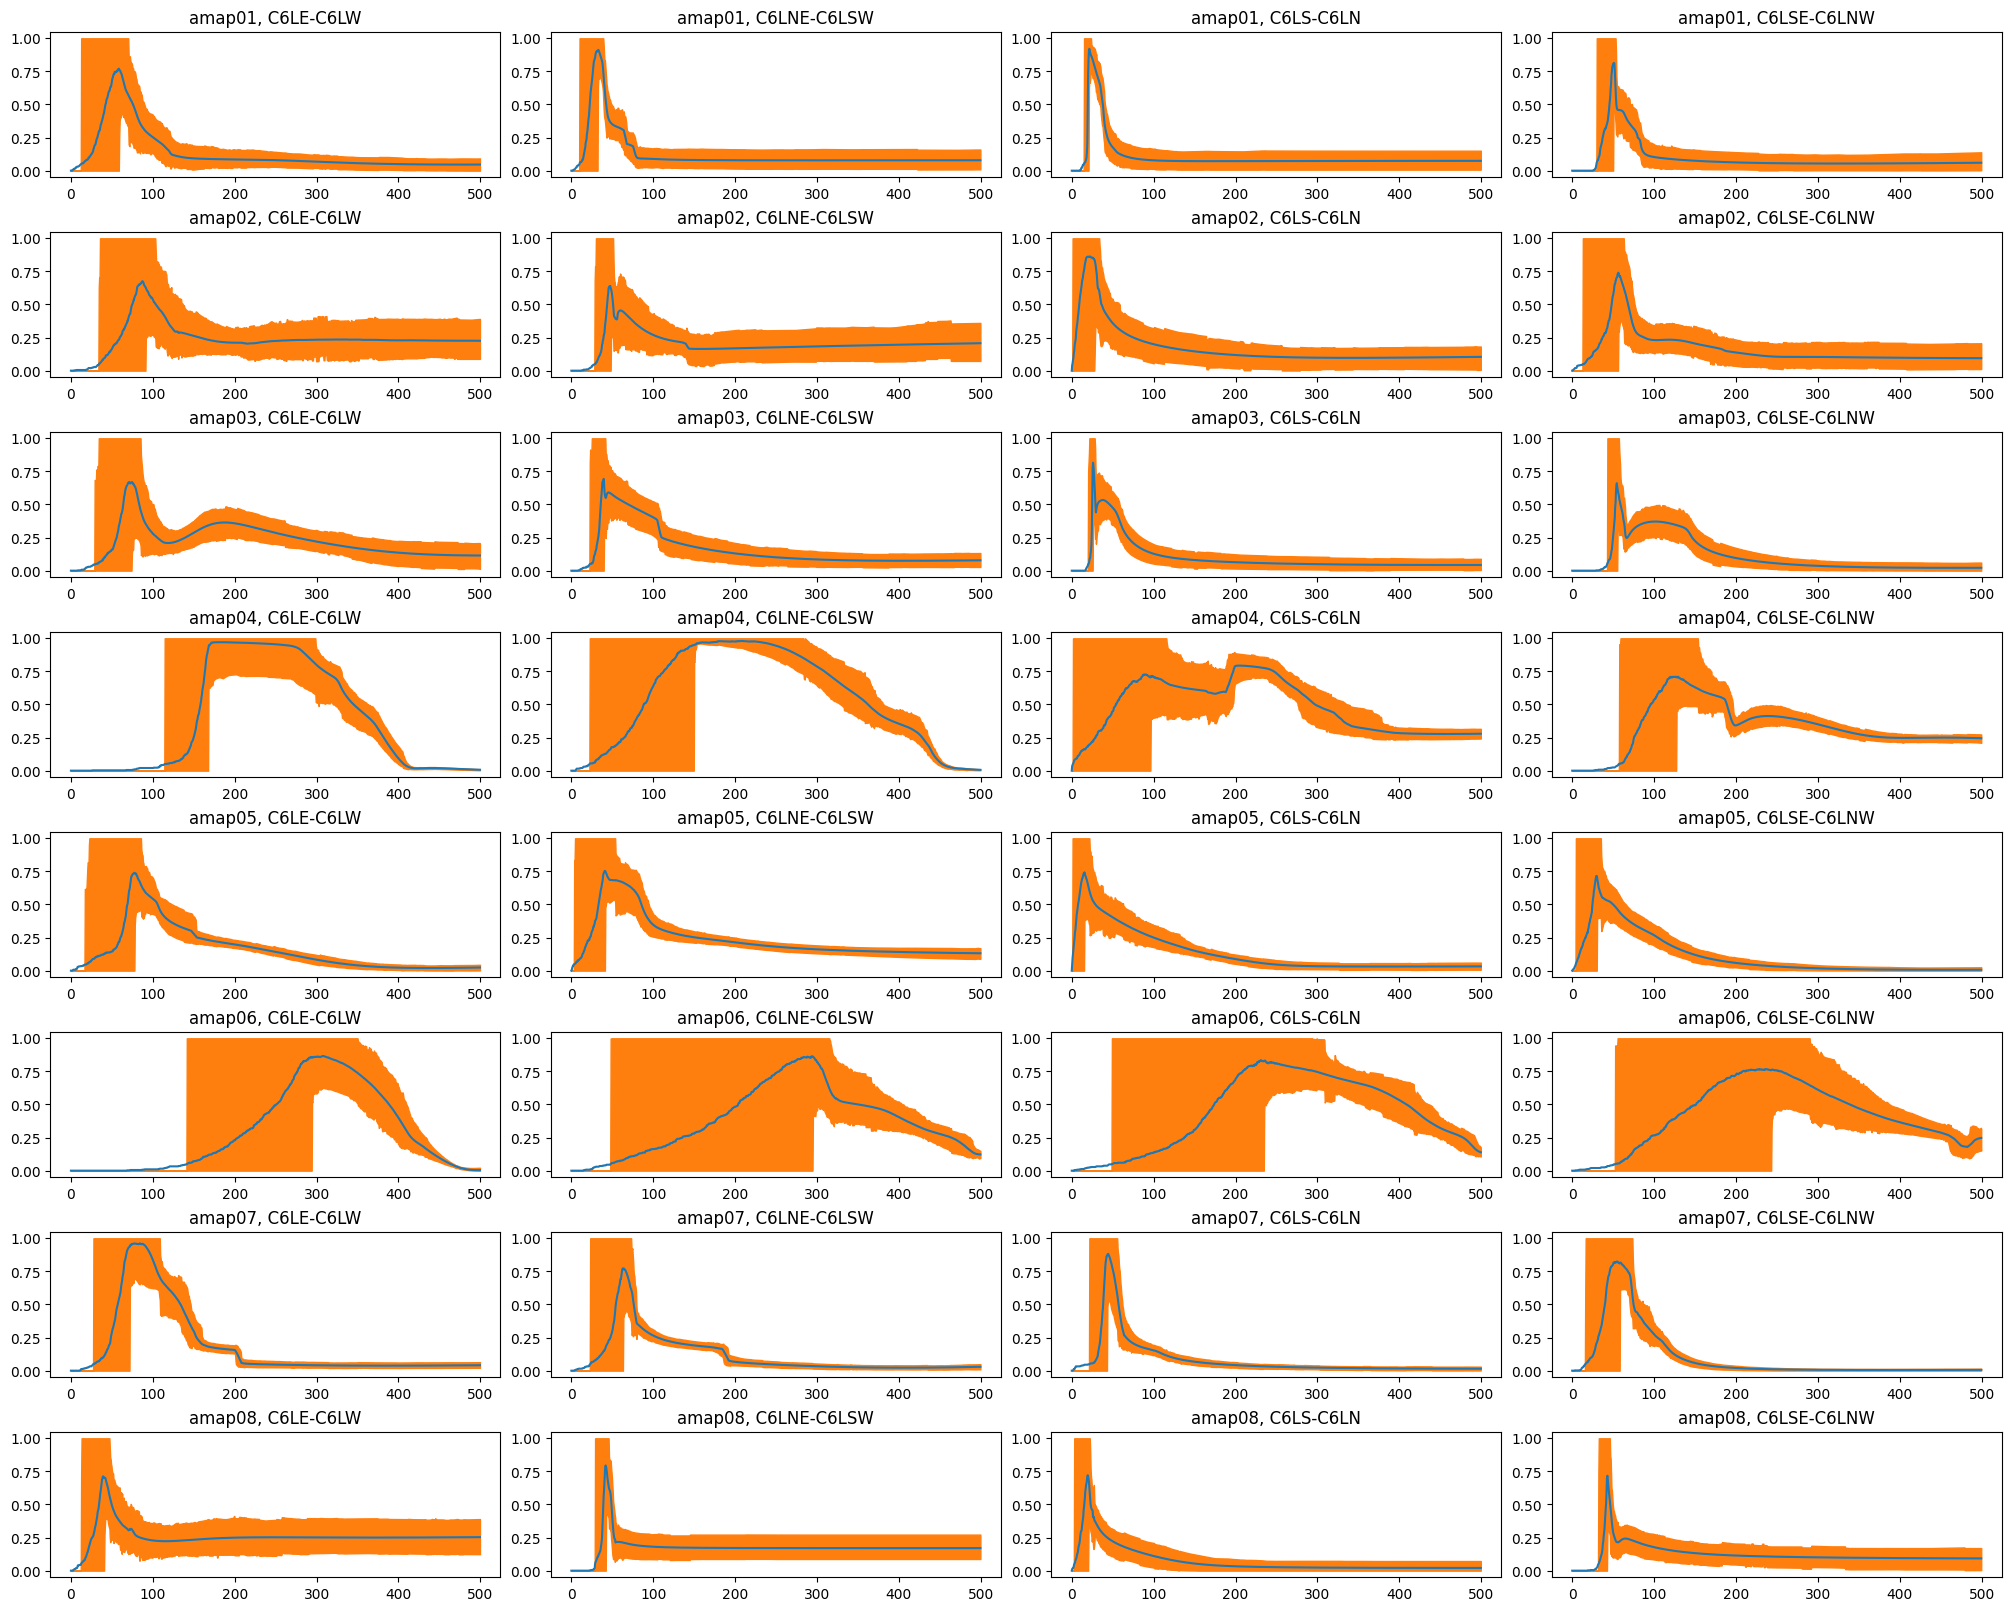

In [78]:
nrows, ncols = len(subjects), (~(entropy_mean.mask)[0, :, 0]).sum()
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, constrained_layout=True, squeeze=False, figsize=(ncols * 5, nrows * 2)
)

for subject_ind, subject in enumerate(subjects):
    j = 0
    for cpos_ind, cpos in enumerate(compound_positions):
        if entropy_mean.mask[subject_ind, cpos_ind, 0]:
            continue

        ax = axes[subject_ind, j]
        samples = entropy[subject_ind, cpos_ind, :, :]
        samples_mean = samples.mean(axis=0)
        samples_hdi = hpdi(samples, 0.95, axis=0)

        sns.lineplot(x=x, y=samples_mean, ax=ax)
        ax.fill_between(x, samples_hdi[0, :], samples_hdi[1, :], color="C1")
        ax.set_title(f"{subject}, {cpos}")
        j += 1

In [91]:
area.shape

()

In [95]:
area_list = []
for subject_ind, subject in enumerate(subjects):
    j = 0
    for cpos_ind, cpos in enumerate(compound_positions):
        if entropy_mean.mask[subject_ind, cpos_ind, 0]:
            continue
        sample_integrals = entropy[subject_ind, cpos_ind, :, :]
        sample_integrals_mean = sample_integrals.mean(axis=0)
        area = np.trapz(sample_integrals_mean, x)
        area_list.append((subject, cpos, area))
        

In [101]:
area_list

[('amap01', 'C6LE-C6LW', 66.07016726605555),
 ('amap01', 'C6LNE-C6LSW', 62.07948115449304),
 ('amap01', 'C6LS-C6LN', 52.080138609027095),
 ('amap01', 'C6LSE-C6LNW', 47.2921164575271),
 ('amap02', 'C6LE-C6LW', 121.86196250064748),
 ('amap02', 'C6LNE-C6LSW', 101.49142426639786),
 ('amap02', 'C6LS-C6LN', 86.41358939331717),
 ('amap02', 'C6LSE-C6LNW', 79.88049834054745),
 ('amap03', 'C6LE-C6LW', 111.66900005099518),
 ('amap03', 'C6LNE-C6LSW', 80.42666486767668),
 ('amap03', 'C6LS-C6LN', 49.362595446398416),
 ('amap03', 'C6LSE-C6LNW', 54.321316601716994),
 ('amap04', 'C6LE-C6LW', 189.01436377235555),
 ('amap04', 'C6LNE-C6LSW', 272.9772754996543),
 ('amap04', 'C6LS-C6LN', 239.721210716452),
 ('amap04', 'C6LSE-C6LNW', 164.16204991952043),
 ('amap05', 'C6LE-C6LW', 79.34019516809629),
 ('amap05', 'C6LNE-C6LSW', 118.99697757827767),
 ('amap05', 'C6LS-C6LN', 67.71604743058077),
 ('amap05', 'C6LSE-C6LNW', 55.977781240642),
 ('amap06', 'C6LE-C6LW', 145.0454124030172),
 ('amap06', 'C6LNE-C6LSW', 187

In [111]:
check = list(((a[0], a[2]) for a in area_list if a[1] == 'C6LE-C6LW'))


In [112]:
check

[('amap01', 66.07016726605555),
 ('amap02', 121.86196250064748),
 ('amap03', 111.66900005099518),
 ('amap04', 189.01436377235555),
 ('amap05', 79.34019516809629),
 ('amap06', 145.0454124030172),
 ('amap07', 93.62737575786552),
 ('amap08', 128.8247156107372)]

In [123]:
filt_positions = list(set((a[1] for a in area_list)))


In [124]:
filt_positions

['C6LS-C6LN', 'C6LE-C6LW', 'C6LNE-C6LSW', 'C6LSE-C6LNW']

In [194]:
pvalues = []
for pos_ind_one, p_one in enumerate(filt_positions):    
    for pos_ind_two, p_two in enumerate(filt_positions):         
        if pos_ind_one == pos_ind_two:
            pvalues.append((p_one, p_two, 0))
            continue
        group_one = np.array(list(a[2] for a in area_list if a[1] == p_one))
        group_two = np.array(list(a[2] for a in area_list if a[1] == p_two))
        pvalues.append((p_one, p_two, f"{stats.ttest_rel(group_one, group_two, alternative='two-sided')[1]}"))
        
# unique_pvalues = set(tuple(sorted(t)) for t in pvalues)


In [186]:
unique_pvalues

{('0.051046018416915195', 'C6LNE-C6LSW', 'C6LS-C6LN'),
 ('0.060420565402707696', 'C6LNE-C6LSW', 'C6LSE-C6LNW'),
 ('0.0973582277885472', 'C6LE-C6LW', 'C6LSE-C6LNW'),
 ('0.39493251606837165', 'C6LE-C6LW', 'C6LS-C6LN'),
 ('0.423429954802217', 'C6LS-C6LN', 'C6LSE-C6LNW'),
 ('0.8129563480600144', 'C6LE-C6LW', 'C6LNE-C6LSW'),
 ('C6LE-C6LW', 'C6LE-C6LW', 'NA'),
 ('C6LNE-C6LSW', 'C6LNE-C6LSW', 'NA'),
 ('C6LS-C6LN', 'C6LS-C6LN', 'NA'),
 ('C6LSE-C6LNW', 'C6LSE-C6LNW', 'NA')}

In [173]:
unique_pvalues=list(unique_pvalues)

In [195]:
values = list(a[2] for a in pvalues)
labels = list(a[1] for a in pvalues)

In [199]:
values = np.array(values).reshape(4,4)
labels = np.array(labels).reshape(4,4)
values = values.astype(np.float32)

<Axes: >

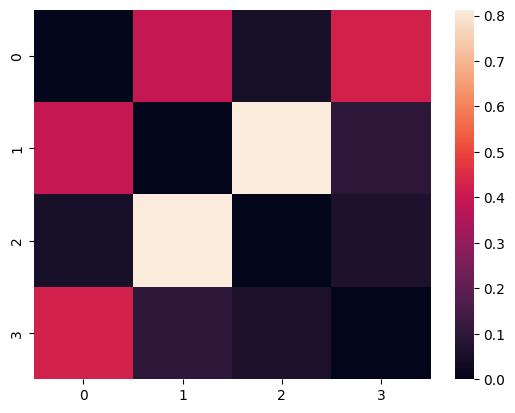

In [210]:
sns.heatmap(values)


In [204]:
sns.heatmap(values, xticklabels=labels)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Error in callback <function _draw_all_if_interactive at 0x7f9bbfaf2ca0> (for post_execute), with arguments args (),kwargs {}:


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 640x480 with 2 Axes>

In [198]:
values

array([['0', '0.39493251606837165', '0.051046018416915195',
        '0.423429954802217'],
       ['0.39493251606837165', '0', '0.8129563480600144',
        '0.0973582277885472'],
       ['0.051046018416915195', '0.8129563480600144', '0',
        '0.060420565402707696'],
       ['0.423429954802217', '0.0973582277885472',
        '0.060420565402707696', '0']], dtype='<U21')